In [ ]:
# @title Conectare la drive
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# @title Imports
!pip install tensorflow-addons

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Dataset


In [ ]:
# @title Path-uri

train_img_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/train/img/cls"
train_bin_mask_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/train/bin_mask/cls"
train_mult_mask_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/train/mult_mask/cls"

validation_img_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/validation/img/cls"
validation_bin_mask_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/validation/bin_mask/cls"
validation_mult_mask_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/validation/mult_mask/cls"

test_img_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/test/img/cls"
test_mask_path = "/content/drive/MyDrive/Facultate/Licenta/ds1/test/mult_mask/cls"

In [ ]:
# @title Incarcam path-urile

def load_paths(imd_dir, mask_dir):
  image_paths = sorted([os.path.join(imd_dir, file_name) for file_name in os.listdir(imd_dir) if file_name.endswith(".tif")])
  mask_paths = sorted([os.path.join(mask_dir, file_name) for file_name in os.listdir(mask_dir) if file_name.endswith(".tif")])
  return image_paths, mask_paths

train_img_paths, train_mask_paths = load_paths(train_img_path, train_mult_mask_path)

validation_img_paths, validation_mask_paths = load_paths(validation_img_path, validation_mult_mask_path)

test_imgs_paths, test_masks_paths = load_paths(test_img_path, test_mask_path)

In [ ]:
# @title Augumentare data

def augment_data(image, mask):
  # Random flip orizontal
  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)

  # Random flip vertical
  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)

  # Random lumina
  if tf.random.uniform(()) > 0.5:
    image = tf.image.random_brightness(image, max_delta=0.2)

  # Random contrast
  if tf.random.uniform(()) > 0.5:
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

  # Random rotire
  angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
  image = tf.image.rot90(image, angle)
  mask = tf.image.rot90(mask, angle)

  return image, mask

In [ ]:
# @title Preprocesare imagine + masca

def load_tif_with_pil(path):
  img = Image.open(path.numpy().decode('utf-8'))
  img = img.convert('L') # Convertim la grayscale
  img = np.array(img, dtype=np.float32)
  return img

def preprocess_mult(img_path, mask_path):
  img = tf.py_function(load_tif_with_pil, [img_path], tf.float32)
  img = tf.expand_dims(img, axis=-1)
  img.set_shape([None, None, 1])
  img = tf.image.resize(img, (256, 256))
  img = (img / 255.0) * 2.0 - 1.01 # Normalizare in intervalul [-1, 1]

  mask = tf.py_function(load_tif_with_pil, [mask_path], tf.float32)
  mask = tf.expand_dims(mask, axis=-1)
  mask.set_shape([None, None, 1])
  mask = tf.image.resize(mask, (256, 256), method='nearest')
  mask = tf.squeeze(mask, axis=-1)          # Scoatem dimensiunea suplimentară
  mask = tf.cast(mask, tf.uint8)
  mask = tf.one_hot(mask, depth=8)           # Convertim la one-hot (8 clase)
  mask = tf.cast(mask, tf.float32)           # TensorFlow vrea float pentru loss

  # Setam shape explicit ca in paper
  img.set_shape([256, 256, 1])
  mask.set_shape([256, 256, 8])

  return img, mask


In [ ]:
# @title Creare Dataset

def create_dataset(img_paths, mask_paths, batch_size=8, shuffle=True, augment=False):
  dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
  dataset = dataset.map(preprocess_mult, num_parallel_calls=tf.data.AUTOTUNE)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=100)

  if augment:
    dataset = dataset.map(lambda img, mask: augment_data(img, mask), num_parallel_calls=tf.data.AUTOTUNE)

  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

train_dataset_unet = create_dataset(train_img_paths, train_mask_paths, batch_size=8, augment=True)

validation_dataset_unet = create_dataset(validation_img_paths, validation_mask_paths, batch_size=8, augment=False)

test_dataset_unet = create_dataset(test_imgs_paths, test_masks_paths, batch_size=8, shuffle=False, augment=False)

print(train_dataset_unet.cardinality().numpy())
print(validation_dataset_unet.cardinality().numpy())
print(test_dataset_unet.cardinality().numpy())

13
13
13


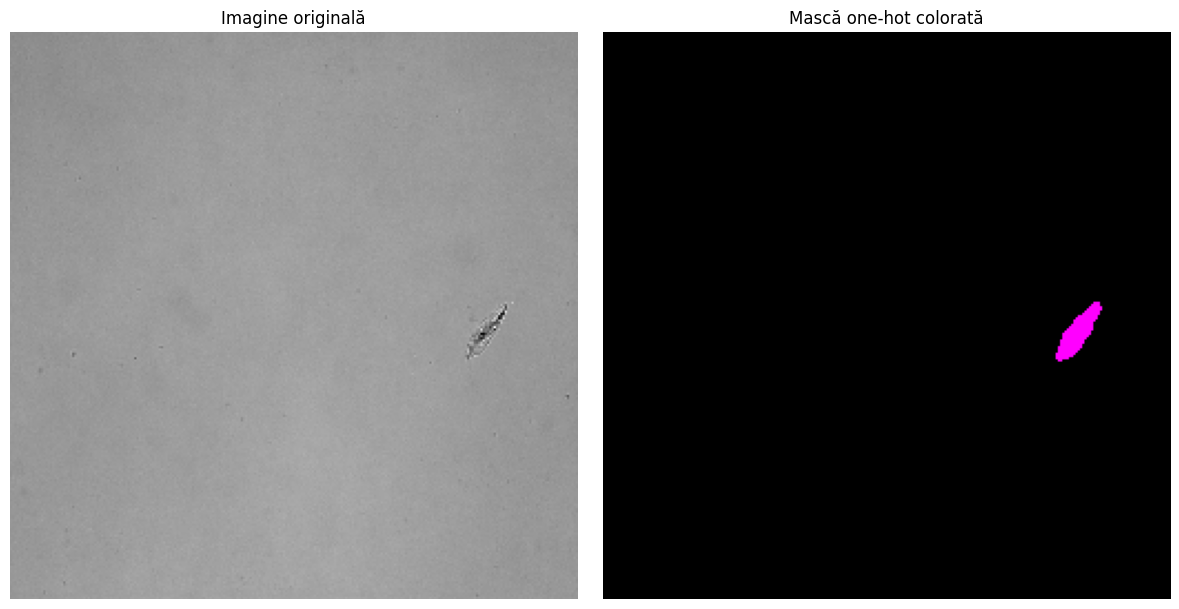

In [ ]:
# Definim culori pentru fiecare clasă (8 culori)
clase_culori = np.array([
    [0, 0, 0],       # Background - negru
    [255, 0, 0],     # Rod - roșu
    [0, 255, 0],     # RBC/WBC - verde
    [0, 0, 255],     # Yeast - albastru
    [255, 255, 0],   # Miscellaneous - galben
    [255, 0, 255],   # Single EPC - magenta
    [0, 255, 255],   # Small EPC sheet - cyan
    [255, 165, 0]    # Large EPC sheet - portocaliu
], dtype=np.uint8)

# Funcție de conversie de la one-hot la imagine colorată
def decode_mask_one_hot(mask_one_hot):
  mask_labels = np.argmax(mask_one_hot, axis=-1)  # (H, W)
  mask_rgb = clase_culori[mask_labels]            # (H, W, 3)
  return mask_rgb

# Selectăm un batch din dataset
for img_batch, mask_batch in train_dataset_unet.take(1):
  img = img_batch[0].numpy()   # Imagine
  mask = mask_batch[0].numpy() # Mască one-hot
  break

# Decodăm masca
decoded_mask = decode_mask_one_hot(mask)

# Plotăm imaginea și masca
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Imaginea originală
axes[0].imshow((img + 1) / 2, cmap='gray')  # Reconvertim din [-1,1] în [0,1]
axes[0].set_title('Imagine originală')
axes[0].axis('off')

# Masca colorată
axes[1].imshow(decoded_mask)
axes[1].set_title('Mască one-hot colorată')
axes[1].axis('off')

plt.tight_layout()
plt.show()


# Loss + Metrici

In [ ]:
# @title Loss: Focal Loss + Multiclass Dice Loss

def focal_loss(class_weights, gamma=2.0):
  class_weights = tf.constant(class_weights, dtype=tf.float32)

  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = class_weights * y_true
    focal = tf.math.pow(1 - y_pred, gamma) * cross_entropy * weight
    return tf.reduce_mean(tf.reduce_sum(focal, axis=-1))  # medie pe batch.
  return loss

def multiclass_dice_loss():
  def loss(y_true, y_pred, smooth=1e-6):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)
  return loss

def combined_loss(class_weights, gamma=2.0, weight_dice=1.0):
  focal_fn = focal_loss(class_weights, gamma)
  dice_fn = multiclass_dice_loss()
  def loss(y_true, y_pred):
    return focal_fn(y_true, y_pred) + weight_dice * dice_fn(y_true, y_pred)
  return loss

In [ ]:
# @title Metrici personalizati

def iou_multiclass(y_true, y_pred):
  # Convertim predictia softmax in argmax
  y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

  # y_true este deja one-hot din dataset. Convertim inapoi la indici pentru comparatie.
  y_true = tf.argmax(y_true, axis=-1, output_type=tf.int32)

  intersection = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
  union = tf.reduce_sum(tf.ones_like(y_true, dtype=tf.float32))

  return intersection / (union + K.epsilon())

def dice_multiclass(y_true, y_pred):
  # y_true este deja one-hot din dataset, shape (batch_size, H, W, num_classes)
  # y_pred are shape (batch_size, H, W, num_classes) dupa softmax
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculeaza intersectia si suma de pixeli pentru fiecare clasa
  # Reduce sum pe dimensiunile spatiale (H, W)
  intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2]) # shape (batch_size, num_classes)
  denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) # shape (batch_size, num_classes)

  # Calculeaza dice score per clasa, per imagine in batch
  dice_per_class_per_image = (2.0 * intersection + K.epsilon()) / (denominator + K.epsilon()) # shape (batch_size, num_classes)

  # Returneaza media dice score pe tot batch-ul (media pe imagini si pe clase)
  return tf.reduce_mean(dice_per_class_per_image)

# U-Net

In [ ]:
# @title Instance Normalization manuala
# InstanceNormalization din TensorFlow Addons din moment ce nu mai e compatibil
# Respecta modelul din paper

class InstanceNormalization(tf.keras.layers.Layer):
  def __init__(self, epsilon=1e-5, **kwargs):
    super().__init__(**kwargs)
    self.epsilon = epsilon

  def build(self, input_shape):
    self.gamma = self.add_weight(shape=(input_shape[-1],),
                                 initializer="ones",
                                 trainable=True)
    self.beta = self.add_weight(shape=(input_shape[-1],),
                                initializer="zeros",
                                trainable=True)
    super(InstanceNormalization, self).build(input_shape)

  def call(self, inputs):
    mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
    inv = tf.sqrt(variance + self.epsilon)
    normalized = (inputs - mean) / inv
    return self.gamma * normalized + self.beta


In [ ]:
# @title U-Net Multi-Class

def conv_block(inputs, filters, dropout_rate=0.2):
  x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal",
                    kernel_regularizer=regularizers.l2(1e-4))(inputs)
  x = InstanceNormalization()(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal",
                    kernel_regularizer=regularizers.l2(1e-4))(x)
  x = InstanceNormalization()(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.SpatialDropout2D(dropout_rate)(x)
  return x

def build_unet_multiclass(input_shape=(256,256,1), num_classes=8, dropout_rate=0.2):
  inputs_tensor = layers.Input(shape=input_shape)

  # Encoder
  c1 = conv_block(inputs_tensor, 32, dropout_rate)
  p1 = layers.MaxPooling2D()(c1)

  c2 = conv_block(p1, 64, dropout_rate)
  p2 = layers.MaxPooling2D()(c2)

  c3 = conv_block(p2, 128, dropout_rate)
  p3 = layers.MaxPooling2D()(c3)

  c4 = conv_block(p3, 256, dropout_rate)
  p4 = layers.MaxPooling2D()(c4)

  # Bottleneck
  c5 = conv_block(p4, 512, dropout_rate)

  # Decoder
  u6 = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(c5)
  u6 = layers.concatenate([u6, c4])
  c6 = conv_block(u6, 256, dropout_rate)

  u7 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c6)
  u7 = layers.concatenate([u7, c3])
  c7 = conv_block(u7, 128, dropout_rate)

  u8 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c7)
  u8 = layers.concatenate([u8, c2])
  c8 = conv_block(u8, 64, dropout_rate)

  u9 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(c8)
  u9 = layers.concatenate([u9, c1])
  c9 = conv_block(u9, 32, dropout_rate)

  # Output
  outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c9)

  model = tf.keras.Model(inputs=inputs_tensor, outputs=outputs, name="U-Net_Multiclass")
  return model

In [ ]:
# @title Compile
from tensorflow.keras.metrics import MeanIoU

class_weights = [1, 20, 5, 15, 10, 1, 5, 15]

unet_model = build_unet_multiclass()
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=combined_loss(class_weights, gamma=2.0, weight_dice=1.0),
    # loss='categorical_crossentropy',
    metrics=[MeanIoU(num_classes=8), dice_multiclass]
)


unet_model.summary()

Model: "U-Net_Multiclass"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 256, 256,  │         64 │ conv2d_76[0][0]   │
│ (InstanceNormaliza… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ instance_normali… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_72 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 256, 256,  │      9,248 │ re_lu_72[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 256, 256,  │         64 │ conv2d_77[0][0]   │
│ (InstanceNormaliza… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ instance_normali… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_73 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 256, 256,  │          0 │ re_lu_73[0][0]    │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 128, 128,  │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 128, 128,  │        128 │ conv2d_78[0][0]   │
│ (InstanceNormaliza… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ instance_normali… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_74 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 128, 128,  │     36,928 │ re_lu_74[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 128, 128,  │        128 │ conv2d_79[0][0] 

 Total params: 7,777,416 (29.67 MB)

 Trainable params: 7,771,528 (29.65 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# @title Verificare distributiei claselor in predictie

import numpy as np

def clase_detectate(pred, denumiri_clase=None):
  """
  pred: tensorul returnat de model, dimensiune (1, H, W, C)
  denumiri_clase: listă opțională cu numele claselor
  """
  pred_argmax = np.argmax(pred[0], axis=-1)  # extragem clasa cu probabilitatea cea mai mare per pixel
  clase_unice, pixeli = np.unique(pred_argmax, return_counts=True)

  print("Distribuție pixeli în predicție:")
  for i, count in zip(clase_unice, pixeli):
    nume = denumiri_clase[i] if denumiri_clase else f"Clasa {i}"
    print(f"{nume}: {count} pixeli")

pred = unet_model.predict(image_batch)  # sau o singură imagine reshape-uită (1, 256, 256, 1)
clase_detectate(pred, denumiri_clase=[
  "Background", "Rod", "RBC/WBC", "Yeast", "Misc", "Single EPC", "Small EPC sheet", "Large EPC sheet"
])

NameError: name 'image_batch' is not defined

In [ ]:
# @title Antrenare

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

training = unet_model.fit(
    train_dataset_unet,
    validation_data=validation_dataset_unet,
    epochs=100,
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - dice_multiclass: 0.0519 - loss: 2.7251 - mean_io_u_3: 0.4375 - val_dice_multiclass: 0.0803 - val_loss: 1.8809 - val_mean_io_u_3: 0.4375
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 606ms/step - dice_multiclass: 0.0822 - loss: 1.8928 - mean_io_u_3: 0.4375 - val_dice_multiclass: 0.0983 - val_loss: 1.4891 - val_mean_io_u_3: 0.4375
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 544ms/step - dice_multiclass: 0.0954 - loss: 1.5572 - mean_io_u_3: 0.4375 - val_dice_multiclass: 0.1030 - val_loss: 1.3508 - val_mean_io_u_3: 0.4375
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 535ms/step - dice_multiclass: 0.1031 - loss: 1.3887 - mean_io_u_3: 0.4375 - val_dice_multiclass: 0.1102 - val_loss: 1.2670 - val_mean_io_u_3: 0.4375
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 631ms/step - dice_multiclass: 0.1073 - loss: 1.2909 - mean_io_u_3: 0.4375 - val_dice_multiclass: 0.1134 - val_loss: 1.2227 - val_mean_io_u_3: 0.4375
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 

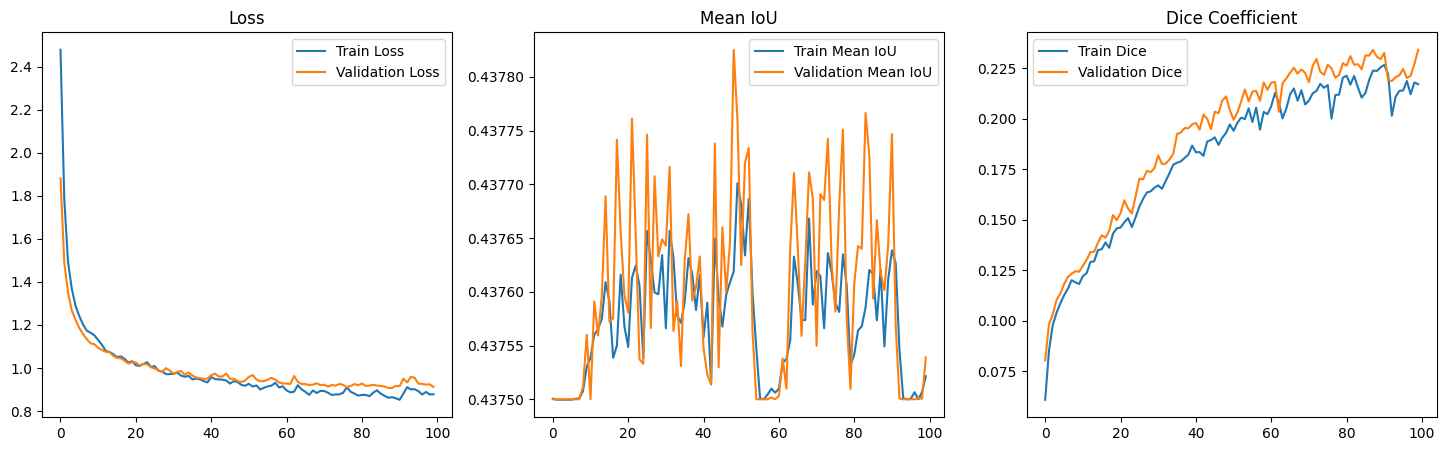

In [ ]:
# Salvare model
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5)) # Increased figure size to accommodate more plots

plt.subplot(1,3,1)
plt.plot(training.history['loss'], label='Train Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(training.history['mean_io_u_3'], label='Train Mean IoU') # Use the metric name added in compile
plt.plot(training.history['val_mean_io_u_3'], label='Validation Mean IoU') # Use the metric name added in compile
plt.title('Mean IoU')
plt.legend()

plt.subplot(1,3,3)
plt.plot(training.history['dice_multiclass'], label='Train Dice') # Use the metric name added in compile
plt.plot(training.history['val_dice_multiclass'], label='Validation Dice') # Use the metric name added in compile
plt.title('Dice Coefficient')
plt.legend()

plt.show()


# Evaluare

In [ ]:
test_results = unet_model.evaluate(test_dataset_unet, verbose=1)

print("Test Loss:", test_results[0])
print("IoU:", test_results[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 511ms/step - dice_multiclass: 0.2327 - loss: 1.0927 - mean_io_u_3: 0.4375
Test Loss: 1.1299638748168945
IoU: 0.4375133812427521


In [ ]:
def calculate_dice_per_class(model, dataset, num_classes=8, smooth=1e-6):
  intersection = np.zeros(num_classes)
  union = np.zeros(num_classes)

  for img_batch, mask_batch in dataset:
    preds = model.predict(img_batch)
    preds = np.argmax(preds, axis=-1)
    masks = np.argmax(mask_batch.numpy(), axis=-1)

    for cls in range(num_classes):
      pred_cls = (preds == cls).astype(np.float32)
      mask_cls = (masks == cls).astype(np.float32)

      intersection[cls] += np.sum(pred_cls * mask_cls)
      union[cls] += np.sum(pred_cls) + np.sum(mask_cls)

  dice_per_class = (2. * intersection + smooth) / (union + smooth)

  print("=== Dice Score per clasă ===")
  for i, score in enumerate(dice_per_class):
    print(f"Clasă {i}: {score:.4f}")

  return dice_per_class

# Apelează funcția
dice_scores = calculate_dice_per_class(unet_model, test_dataset_unet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
=== Dice Score per clasă ===
Clasă 0: 0.9949
Clasă 1: 0.1279
Clasă 2: 0.6138
Clasă 3: 0.0000
Clasă 4: 0.0748
Clasă 5: 0.6592
Clasă 6: 0.0827
Clasă 7: 0.2634


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


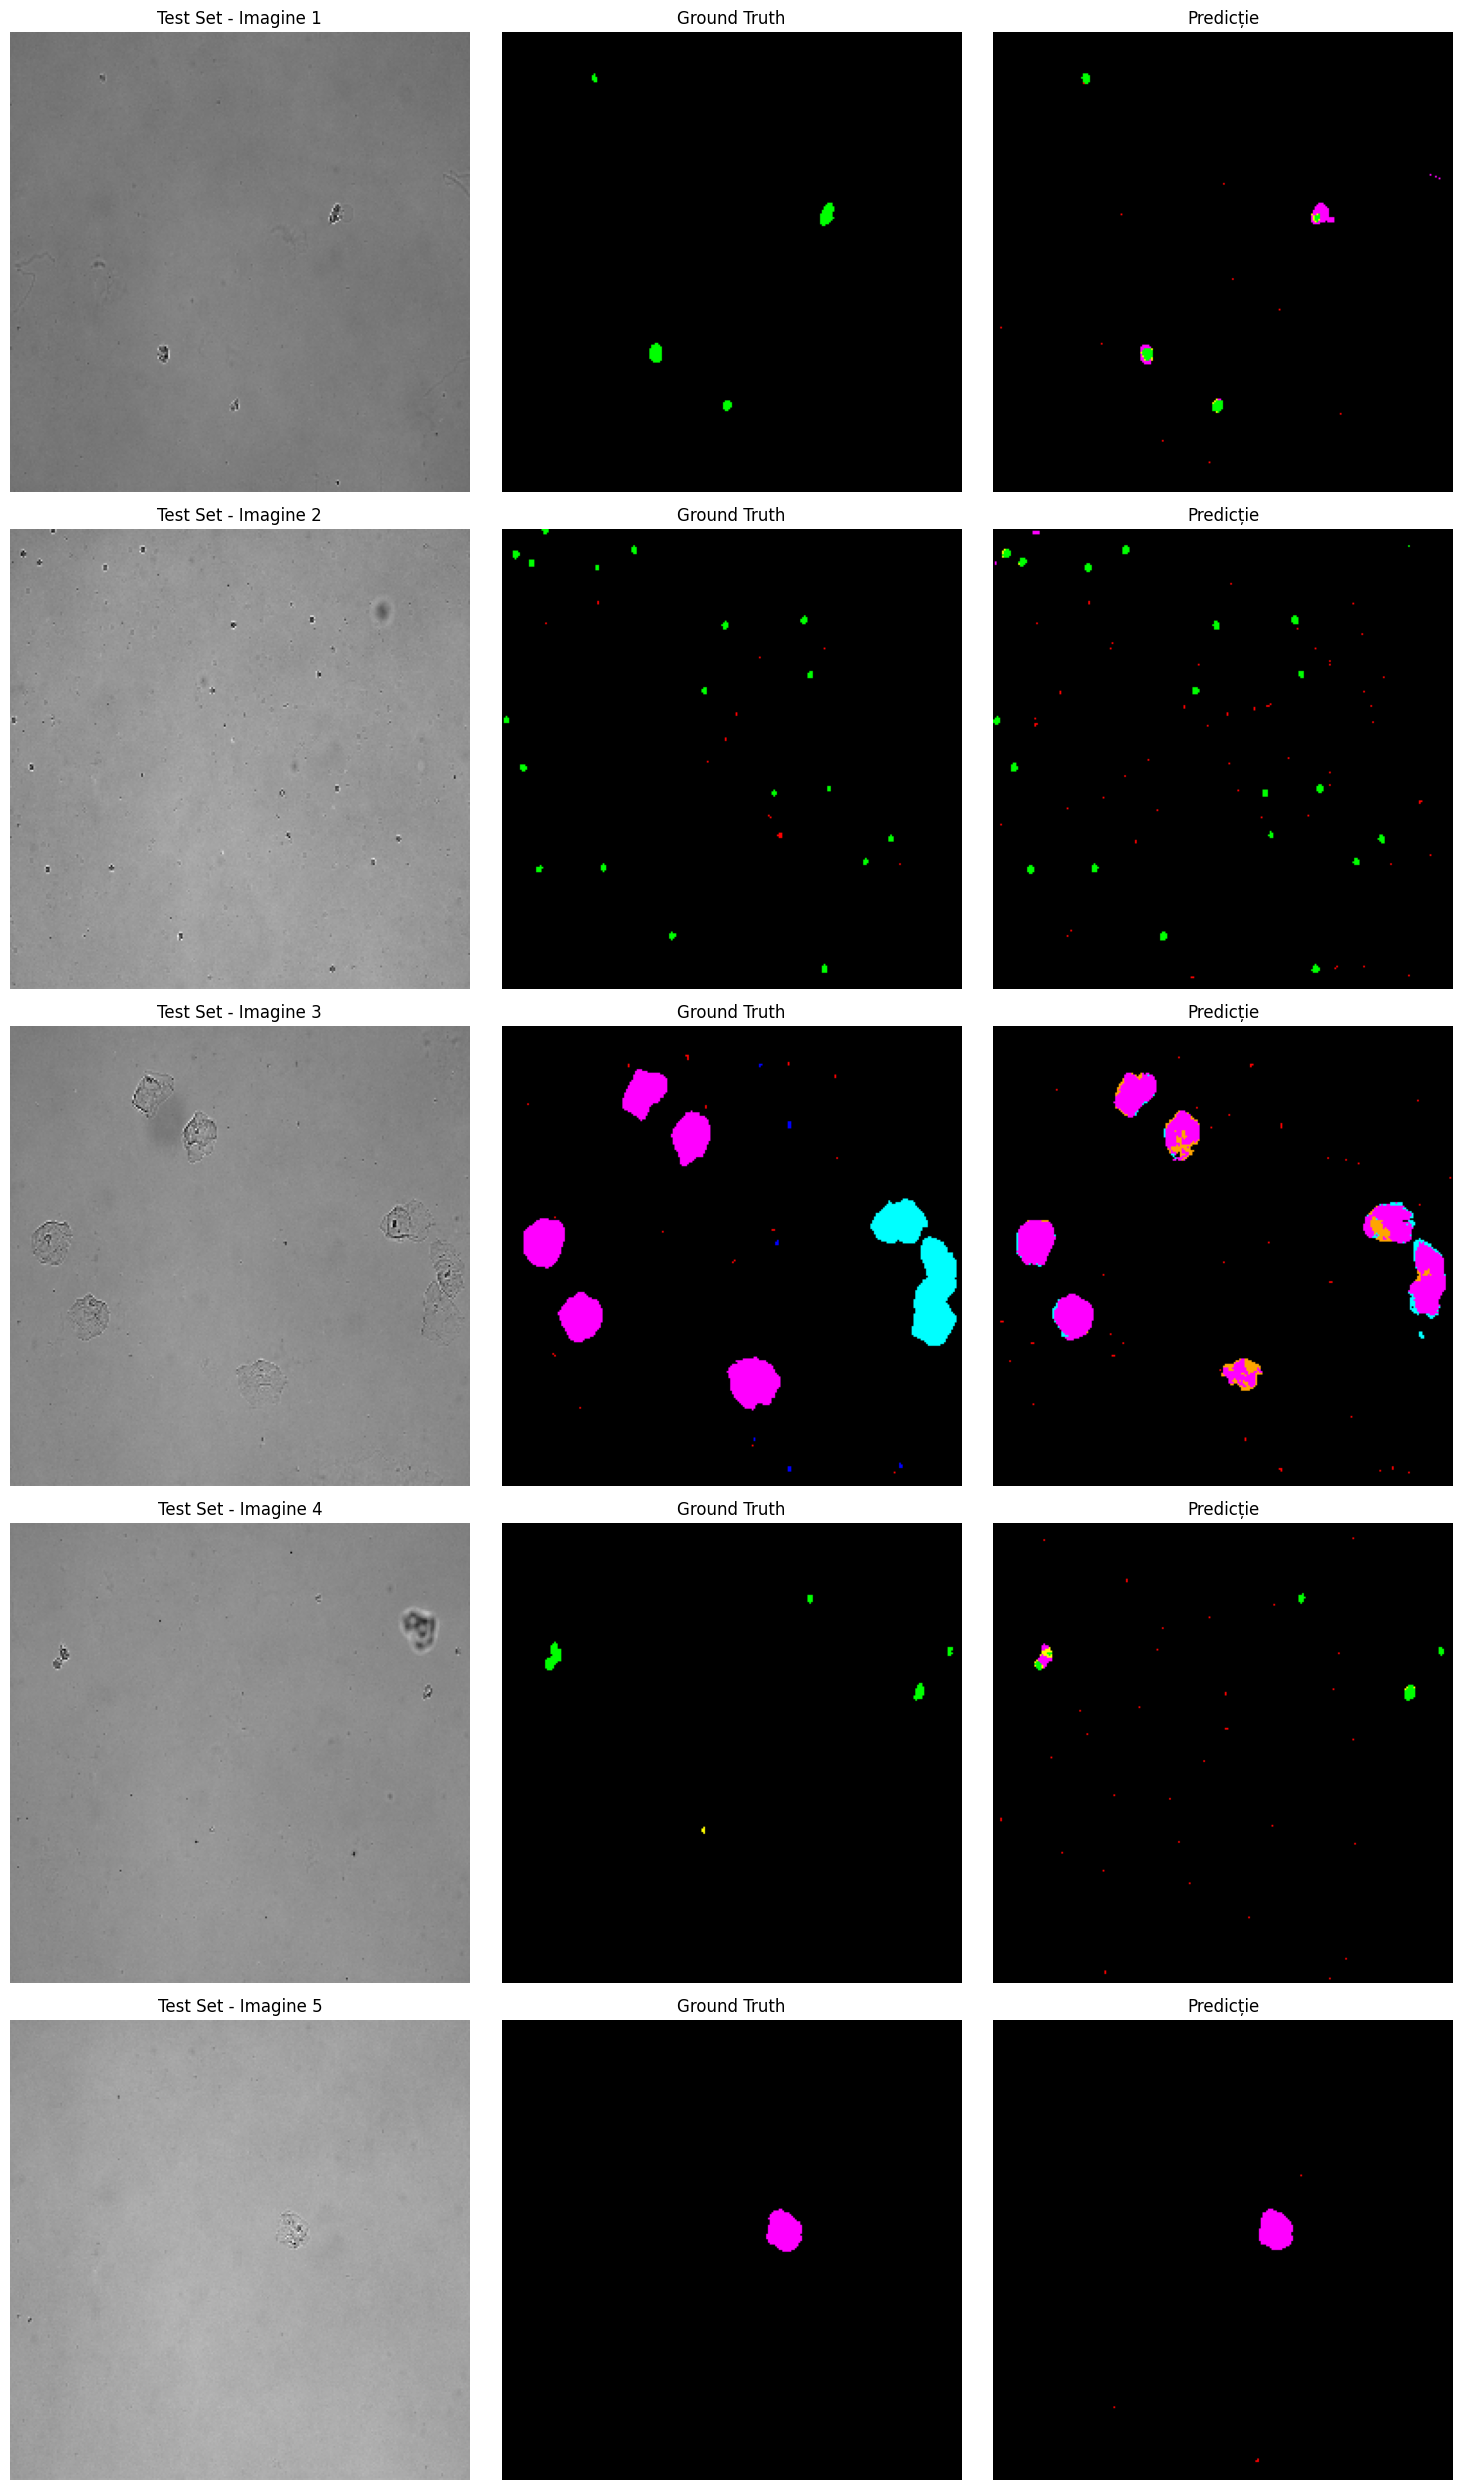

In [ ]:
import matplotlib.pyplot as plt

# Culori RGB pentru cele 8 clase
clase_culori = np.array([
    [0, 0, 0],       # 0 - Background
    [255, 0, 0],     # 1 - Rod
    [0, 255, 0],     # 2 - RBC/WBC
    [0, 0, 255],     # 3 - Yeast
    [255, 255, 0],   # 4 - Misc
    [255, 0, 255],   # 5 - Single EPC
    [0, 255, 255],   # 6 - Small EPC sheet
    [255, 165, 0]    # 7 - Large EPC sheet
], dtype=np.uint8)

def decode_mask(mask_one_hot):
  mask_labels = np.argmax(mask_one_hot, axis=-1)
  return clase_culori[mask_labels]

def vizualizeaza_predictii(model, dataset, nume_dataset="Test Set", nume_model="Model", nume_pred="Predicție", n=5):
  fig, axes = plt.subplots(n, 3, figsize=(15, 5 * n))
  for i, (img_batch, mask_batch) in enumerate(dataset.take(n)):
    img = img_batch[0].numpy()
    mask_true = mask_batch[0].numpy()

    pred = model.predict(np.expand_dims(img, axis=0))[0]
    img_display = ((img + 1) / 2).squeeze()

    mask_true_rgb = decode_mask(mask_true)
    mask_pred_rgb = decode_mask(pred)

    axes[i, 0].imshow(img_display, cmap='gray')
    axes[i, 0].set_title(f"{nume_dataset} - Imagine {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_true_rgb)
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(mask_pred_rgb)
    axes[i, 2].set_title(nume_pred)
    axes[i, 2].axis('off')

  plt.tight_layout()
  plt.show()

# Apelează funcția
vizualizeaza_predictii(unet_model, test_dataset_unet, n=5)